In [1]:
%matplotlib inline

In [58]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.utils import multi_gpu_model
# import tensorflow as tf; tf.Session(config=tf.ConfigProto(log_device_placement=True))

import nengo
from nengolib.synapses import DiscreteDelay

In [3]:
from nengolib.rnn import DelayCell, InputScaled

In [4]:
def generate_data(n_batches, length, n_outputs, dt, theta, freq, rng=np.random):
    process = nengo.processes.WhiteSignal(length * dt, high=freq, y0=0)
    
    t = process.ntrange(length, dt=dt)
    X = np.empty((n_batches, length, 1))  # 1 input
    Y = np.empty((n_batches, length, n_outputs))
    
    delay = int(theta / dt)
    # A single step of the delay will be removed if using the ``filt`` method.
    s = np.linspace(delay+1, 1, n_outputs, dtype=int)
    
    def _generate(x, y):
        x[...] = process.run_steps(length, dt=dt, rng=rng)
        x[...] /= np.max(np.abs(x))
        for i in range(n_outputs):  # TODO: do this more efficiently
            y[:, i] = DiscreteDelay(s[i]).filt(x, dt=None).squeeze()

    for i in range(n_batches):
        _generate(X[i, :], Y[i, :])
    
    return t, s*dt, X, Y

theta = 0.2
dt = 0.0002
freq = 30
n_outputs = 50
seed = 0

t, thetas, X, Y = generate_data(
    n_batches=256, length=int(1./dt), n_outputs=n_outputs,
    dt=dt, theta=theta, freq=freq,
    rng=np.random.RandomState(seed=seed))

split = 0.5
cutoff = int(split*X.shape[0])

train_X = X[:cutoff]
train_Y = Y[:cutoff]

test_X = X[cutoff:]
test_Y = Y[cutoff:]

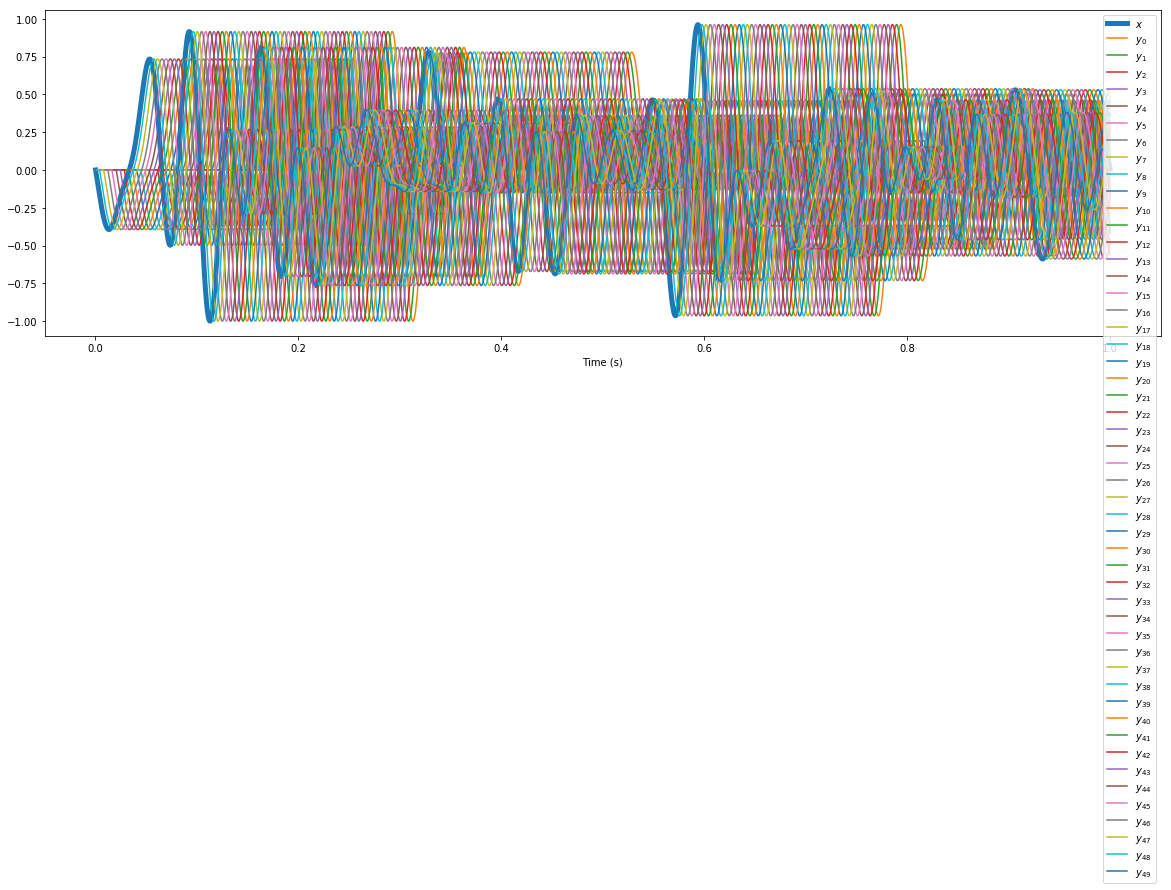

In [5]:
plt.figure(figsize=(20, 6))
plt.plot(t, X[0], label="$x$", lw=5)
for i in range(Y.shape[-1]):
    plt.plot(t, Y[0, :, i], label="$y_{%d}$" % i)
plt.legend()
plt.xlabel("Time (s)")
plt.show()

In [64]:
n_gpus = 4

def make_lstm(num_units, num_layers):
    model = Sequential()
    model.add(LSTM(num_units,
                   input_shape=(X.shape[1], 1),  # (timesteps, input_dims)
                   return_sequences=True))  # continuously outputs per timestep
    for _ in range(num_layers-1):
        model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(Y.shape[-1], activation='tanh'))

    model = multi_gpu_model(model, gpus=n_gpus)
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

def delay_layer(num_units, **kwargs):
    return RNN(DelayCell(num_units,
                         order=9,
                         #theta_initializer=RandomUniform(25, 50),
                         #encoder_initializer='lecun_uniform',
                         #decoder_initializer='lecun_normal',
                         #trainable_A=True,
                         #trainable_B=True,
                        ),
               return_sequences=True,
               **kwargs)

def make_dn(num_units, num_layers):
    model = Sequential()
    model.add(delay_layer(num_units,
                          input_shape=(X.shape[1], 1)))  # (timesteps, input_dims)
    for _ in range(num_layers-1):
        model.add(delay_layer(num_units))
    model.add(Dense(Y.shape[-1], activation='linear'))
    
    model = multi_gpu_model(model, gpus=n_gpus)
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

num_units = 50
num_layers = 3
lstm_model = make_lstm(num_units, num_layers) 
dn_model = make_dn(num_units, num_layers) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lstm_17_input (InputLayer)      (None, 5000, 1)      0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 5000, 1)      0           lstm_17_input[0][0]              
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 5000, 1)      0           lstm_17_input[0][0]              
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 5000, 1)      0           lstm_17_input[0][0]              
__________________________________________________________________________________________________
lambda_12 

In [65]:
from keras.callbacks import EarlyStopping
import time

callbacks = []#EarlyStopping(monitor='val_loss', patience=5)]
             #DisplayThetas()]

def fit(model):
    start = time.time()
    epochs = 500
    result = model.fit(
        train_X, train_Y, batch_size=32,
        epochs=epochs, callbacks=callbacks, validation_split=0.25)
    return result, (time.time() - start) / epochs

In [66]:
lstm_history, lstm_time = fit(lstm_model)

Train on 96 samples, validate on 32 samples
Epoch 1/500
96/96 [==============================] - 113s 1s/step - loss: 0.1126 - val_loss: 0.1090
Epoch 2/500
96/96 [==============================] - 102s 1s/step - loss: 0.1116 - val_loss: 0.1080
Epoch 3/500
96/96 [==============================] - 103s 1s/step - loss: 0.1105 - val_loss: 0.1068
Epoch 4/500
96/96 [==============================] - 102s 1s/step - loss: 0.1092 - val_loss: 0.1057
Epoch 5/500
96/96 [==============================] - 102s 1s/step - loss: 0.1082 - val_loss: 0.1047
Epoch 6/500
96/96 [==============================] - 103s 1s/step - loss: 0.1072 - val_loss: 0.1038
Epoch 7/500
96/96 [==============================] - 102s 1s/step - loss: 0.1063 - val_loss: 0.1029
Epoch 8/500
96/96 [==============================] - 102s 1s/step - loss: 0.1055 - val_loss: 0.1021
Epoch 9/500
96/96 [==============================] - 102s 1s/step - loss: 0.1047 - val_loss: 0.1013
Epoch 10/500
96/96 [==============================] - 10

96/96 [==============================] - 103s 1s/step - loss: 0.0768 - val_loss: 0.0751
Epoch 82/500
96/96 [==============================] - 102s 1s/step - loss: 0.0768 - val_loss: 0.0751
Epoch 83/500
96/96 [==============================] - 102s 1s/step - loss: 0.0764 - val_loss: 0.0750
Epoch 84/500
96/96 [==============================] - 104s 1s/step - loss: 0.0762 - val_loss: 0.0749
Epoch 85/500
96/96 [==============================] - 103s 1s/step - loss: 0.0762 - val_loss: 0.0743
Epoch 86/500
96/96 [==============================] - 102s 1s/step - loss: 0.0759 - val_loss: 0.0742
Epoch 87/500
96/96 [==============================] - 102s 1s/step - loss: 0.0758 - val_loss: 0.0740
Epoch 88/500
96/96 [==============================] - 103s 1s/step - loss: 0.0757 - val_loss: 0.0737
Epoch 89/500
96/96 [==============================] - 103s 1s/step - loss: 0.0757 - val_loss: 0.0737
Epoch 90/500
96/96 [==============================] - 102s 1s/step - loss: 0.0758 - val_loss: 0.0741
Epo

96/96 [==============================] - 102s 1s/step - loss: 0.0640 - val_loss: 0.0627
Epoch 162/500
96/96 [==============================] - 103s 1s/step - loss: 0.0637 - val_loss: 0.0620
Epoch 163/500
96/96 [==============================] - 102s 1s/step - loss: 0.0634 - val_loss: 0.0623
Epoch 164/500
96/96 [==============================] - 102s 1s/step - loss: 0.0629 - val_loss: 0.0625
Epoch 165/500
96/96 [==============================] - 102s 1s/step - loss: 0.0645 - val_loss: 0.0631
Epoch 166/500
96/96 [==============================] - 103s 1s/step - loss: 0.0650 - val_loss: 0.0624
Epoch 167/500
96/96 [==============================] - 102s 1s/step - loss: 0.0638 - val_loss: 0.0634
Epoch 168/500
96/96 [==============================] - 102s 1s/step - loss: 0.0639 - val_loss: 0.0614
Epoch 169/500
96/96 [==============================] - 102s 1s/step - loss: 0.0632 - val_loss: 0.0623
Epoch 170/500
96/96 [==============================] - 102s 1s/step - loss: 0.0629 - val_loss: 0

96/96 [==============================] - 102s 1s/step - loss: 0.0606 - val_loss: 0.0595
Epoch 242/500
96/96 [==============================] - 102s 1s/step - loss: 0.0605 - val_loss: 0.0604
Epoch 243/500
96/96 [==============================] - 102s 1s/step - loss: 0.0605 - val_loss: 0.0599
Epoch 244/500
96/96 [==============================] - 103s 1s/step - loss: 0.0613 - val_loss: 0.0622
Epoch 245/500
96/96 [==============================] - 103s 1s/step - loss: 0.0615 - val_loss: 0.0609
Epoch 246/500
96/96 [==============================] - 103s 1s/step - loss: 0.0618 - val_loss: 0.0611
Epoch 247/500
96/96 [==============================] - 103s 1s/step - loss: 0.0610 - val_loss: 0.0588
Epoch 248/500
96/96 [==============================] - 103s 1s/step - loss: 0.0606 - val_loss: 0.0597
Epoch 249/500
96/96 [==============================] - 102s 1s/step - loss: 0.0603 - val_loss: 0.0602
Epoch 250/500
96/96 [==============================] - 102s 1s/step - loss: 0.0596 - val_loss: 0

96/96 [==============================] - 102s 1s/step - loss: 0.0521 - val_loss: 0.0515
Epoch 323/500
96/96 [==============================] - 102s 1s/step - loss: 0.0522 - val_loss: 0.0517
Epoch 324/500
96/96 [==============================] - 102s 1s/step - loss: 0.0522 - val_loss: 0.0514
Epoch 325/500
96/96 [==============================] - 102s 1s/step - loss: 0.0526 - val_loss: 0.0515
Epoch 326/500
96/96 [==============================] - 102s 1s/step - loss: 0.0523 - val_loss: 0.0523
Epoch 327/500
96/96 [==============================] - 103s 1s/step - loss: 0.0528 - val_loss: 0.0519
Epoch 328/500
96/96 [==============================] - 103s 1s/step - loss: 0.0527 - val_loss: 0.0513
Epoch 329/500
96/96 [==============================] - 103s 1s/step - loss: 0.0521 - val_loss: 0.0516
Epoch 330/500
96/96 [==============================] - 103s 1s/step - loss: 0.0523 - val_loss: 0.0521
Epoch 331/500
96/96 [==============================] - 102s 1s/step - loss: 0.0527 - val_loss: 0

96/96 [==============================] - 102s 1s/step - loss: 0.0521 - val_loss: 0.0510
Epoch 403/500
96/96 [==============================] - 102s 1s/step - loss: 0.0510 - val_loss: 0.0523
Epoch 404/500
96/96 [==============================] - 102s 1s/step - loss: 0.0516 - val_loss: 0.0513
Epoch 405/500
96/96 [==============================] - 103s 1s/step - loss: 0.0504 - val_loss: 0.0490
Epoch 406/500
96/96 [==============================] - 103s 1s/step - loss: 0.0492 - val_loss: 0.0496
Epoch 407/500
96/96 [==============================] - 103s 1s/step - loss: 0.0495 - val_loss: 0.0473
Epoch 408/500
96/96 [==============================] - 103s 1s/step - loss: 0.0479 - val_loss: 0.0471
Epoch 409/500
96/96 [==============================] - 102s 1s/step - loss: 0.0477 - val_loss: 0.0463
Epoch 410/500
96/96 [==============================] - 103s 1s/step - loss: 0.0465 - val_loss: 0.0462
Epoch 411/500
96/96 [==============================] - 102s 1s/step - loss: 0.0462 - val_loss: 0

96/96 [==============================] - 103s 1s/step - loss: 0.0431 - val_loss: 0.0420
Epoch 483/500
96/96 [==============================] - 102s 1s/step - loss: 0.0424 - val_loss: 0.0425
Epoch 484/500
96/96 [==============================] - 103s 1s/step - loss: 0.0423 - val_loss: 0.0414
Epoch 485/500
96/96 [==============================] - 102s 1s/step - loss: 0.0417 - val_loss: 0.0411
Epoch 486/500
96/96 [==============================] - 103s 1s/step - loss: 0.0414 - val_loss: 0.0411
Epoch 487/500
96/96 [==============================] - 103s 1s/step - loss: 0.0413 - val_loss: 0.0407
Epoch 488/500
96/96 [==============================] - 103s 1s/step - loss: 0.0412 - val_loss: 0.0412
Epoch 489/500
96/96 [==============================] - 103s 1s/step - loss: 0.0412 - val_loss: 0.0409
Epoch 490/500
96/96 [==============================] - 103s 1s/step - loss: 0.0411 - val_loss: 0.0407
Epoch 491/500
96/96 [==============================] - 102s 1s/step - loss: 0.0409 - val_loss: 0

In [67]:
dn_history, dn_time = fit(dn_model)

Train on 96 samples, validate on 32 samples
Epoch 1/500
96/96 [==============================] - 59s 616ms/step - loss: 0.1142 - val_loss: 0.1095
Epoch 2/500
96/96 [==============================] - 52s 544ms/step - loss: 0.1120 - val_loss: 0.1082
Epoch 3/500
96/96 [==============================] - 52s 546ms/step - loss: 0.1104 - val_loss: 0.1059
Epoch 4/500
96/96 [==============================] - 53s 547ms/step - loss: 0.1075 - val_loss: 0.1019
Epoch 5/500
96/96 [==============================] - 52s 546ms/step - loss: 0.1028 - val_loss: 0.0964
Epoch 6/500
96/96 [==============================] - 52s 545ms/step - loss: 0.0968 - val_loss: 0.0902
Epoch 7/500
96/96 [==============================] - 52s 545ms/step - loss: 0.0900 - val_loss: 0.0833
Epoch 8/500
96/96 [==============================] - 52s 544ms/step - loss: 0.0830 - val_loss: 0.0766
Epoch 9/500
96/96 [==============================] - 52s 546ms/step - loss: 0.0760 - val_loss: 0.0701
Epoch 10/500
96/96 [==================

96/96 [==============================] - 53s 548ms/step - loss: 9.8407e-04 - val_loss: 0.0011
Epoch 81/500
96/96 [==============================] - 52s 547ms/step - loss: 9.6520e-04 - val_loss: 0.0010
Epoch 82/500
96/96 [==============================] - 53s 547ms/step - loss: 9.4601e-04 - val_loss: 9.9657e-04
Epoch 83/500
96/96 [==============================] - 52s 546ms/step - loss: 9.2378e-04 - val_loss: 9.7916e-04
Epoch 84/500
96/96 [==============================] - 52s 546ms/step - loss: 9.1197e-04 - val_loss: 9.8962e-04
Epoch 85/500
96/96 [==============================] - 53s 548ms/step - loss: 8.9828e-04 - val_loss: 9.8180e-04
Epoch 86/500
96/96 [==============================] - 52s 546ms/step - loss: 9.1090e-04 - val_loss: 9.3768e-04
Epoch 87/500
96/96 [==============================] - 52s 547ms/step - loss: 8.6771e-04 - val_loss: 9.1655e-04
Epoch 88/500
96/96 [==============================] - 52s 546ms/step - loss: 8.4457e-04 - val_loss: 9.0526e-04
Epoch 89/500
96/96 [==

96/96 [==============================] - 52s 546ms/step - loss: 4.1596e-04 - val_loss: 4.7542e-04
Epoch 154/500
96/96 [==============================] - 52s 546ms/step - loss: 4.1451e-04 - val_loss: 4.6617e-04
Epoch 155/500
96/96 [==============================] - 53s 549ms/step - loss: 4.0814e-04 - val_loss: 4.5072e-04
Epoch 156/500
96/96 [==============================] - 53s 549ms/step - loss: 4.0196e-04 - val_loss: 4.5027e-04
Epoch 157/500
96/96 [==============================] - 53s 549ms/step - loss: 3.9976e-04 - val_loss: 4.4757e-04
Epoch 158/500
96/96 [==============================] - 52s 544ms/step - loss: 3.9984e-04 - val_loss: 4.6743e-04
Epoch 159/500
96/96 [==============================] - 53s 550ms/step - loss: 4.0939e-04 - val_loss: 4.4412e-04
Epoch 160/500
96/96 [==============================] - 53s 550ms/step - loss: 4.0050e-04 - val_loss: 4.4538e-04
Epoch 161/500
96/96 [==============================] - 53s 548ms/step - loss: 3.9734e-04 - val_loss: 4.3730e-04
Epoch 

96/96 [==============================] - 52s 546ms/step - loss: 2.6760e-04 - val_loss: 2.9790e-04
Epoch 227/500
96/96 [==============================] - 52s 546ms/step - loss: 2.6089e-04 - val_loss: 3.0128e-04
Epoch 228/500
96/96 [==============================] - 52s 547ms/step - loss: 2.6754e-04 - val_loss: 3.2082e-04
Epoch 229/500
96/96 [==============================] - 53s 548ms/step - loss: 2.8562e-04 - val_loss: 3.2352e-04
Epoch 230/500
96/96 [==============================] - 53s 548ms/step - loss: 2.8669e-04 - val_loss: 2.9336e-04
Epoch 231/500
96/96 [==============================] - 53s 550ms/step - loss: 2.7461e-04 - val_loss: 3.1708e-04
Epoch 232/500
96/96 [==============================] - 52s 546ms/step - loss: 2.7291e-04 - val_loss: 2.9840e-04
Epoch 233/500
96/96 [==============================] - 52s 546ms/step - loss: 2.6023e-04 - val_loss: 3.1084e-04
Epoch 234/500
96/96 [==============================] - 52s 545ms/step - loss: 2.6499e-04 - val_loss: 2.9259e-04
Epoch 

96/96 [==============================] - 53s 547ms/step - loss: 1.9647e-04 - val_loss: 2.3217e-04
Epoch 300/500
96/96 [==============================] - 52s 547ms/step - loss: 1.9638e-04 - val_loss: 2.2883e-04
Epoch 301/500
96/96 [==============================] - 53s 549ms/step - loss: 1.9281e-04 - val_loss: 2.2379e-04
Epoch 302/500
96/96 [==============================] - 52s 547ms/step - loss: 2.0142e-04 - val_loss: 2.3181e-04
Epoch 303/500
96/96 [==============================] - 53s 549ms/step - loss: 2.0169e-04 - val_loss: 2.3115e-04
Epoch 304/500
96/96 [==============================] - 52s 545ms/step - loss: 2.0592e-04 - val_loss: 2.2905e-04
Epoch 305/500
96/96 [==============================] - 52s 547ms/step - loss: 2.0668e-04 - val_loss: 2.2993e-04
Epoch 306/500
96/96 [==============================] - 52s 546ms/step - loss: 2.0523e-04 - val_loss: 2.3938e-04
Epoch 307/500
96/96 [==============================] - 52s 546ms/step - loss: 2.0228e-04 - val_loss: 2.2826e-04
Epoch 

96/96 [==============================] - 52s 545ms/step - loss: 1.8873e-04 - val_loss: 2.0864e-04
Epoch 373/500
96/96 [==============================] - 53s 548ms/step - loss: 1.7628e-04 - val_loss: 2.2385e-04
Epoch 374/500
96/96 [==============================] - 52s 546ms/step - loss: 1.7690e-04 - val_loss: 2.1140e-04
Epoch 375/500
96/96 [==============================] - 53s 547ms/step - loss: 1.7583e-04 - val_loss: 2.0971e-04
Epoch 376/500
96/96 [==============================] - 53s 547ms/step - loss: 1.7075e-04 - val_loss: 2.0115e-04
Epoch 377/500
96/96 [==============================] - 53s 548ms/step - loss: 1.6666e-04 - val_loss: 2.1373e-04
Epoch 378/500
96/96 [==============================] - 53s 547ms/step - loss: 1.7603e-04 - val_loss: 1.9798e-04
Epoch 379/500
96/96 [==============================] - 52s 545ms/step - loss: 1.6136e-04 - val_loss: 1.8856e-04
Epoch 380/500
96/96 [==============================] - 52s 546ms/step - loss: 1.6221e-04 - val_loss: 1.9161e-04
Epoch 

96/96 [==============================] - 53s 548ms/step - loss: 1.5824e-04 - val_loss: 1.7791e-04
Epoch 446/500
96/96 [==============================] - 52s 544ms/step - loss: 1.5229e-04 - val_loss: 2.0336e-04
Epoch 447/500
96/96 [==============================] - 52s 544ms/step - loss: 1.6225e-04 - val_loss: 1.6706e-04
Epoch 448/500
96/96 [==============================] - 53s 547ms/step - loss: 1.4521e-04 - val_loss: 1.8122e-04
Epoch 449/500
96/96 [==============================] - 52s 546ms/step - loss: 1.4967e-04 - val_loss: 1.6584e-04
Epoch 450/500
96/96 [==============================] - 53s 548ms/step - loss: 1.3868e-04 - val_loss: 1.7202e-04
Epoch 451/500
96/96 [==============================] - 52s 547ms/step - loss: 1.4115e-04 - val_loss: 1.5923e-04
Epoch 452/500
96/96 [==============================] - 52s 546ms/step - loss: 1.3436e-04 - val_loss: 1.6582e-04
Epoch 453/500
96/96 [==============================] - 53s 549ms/step - loss: 1.3453e-04 - val_loss: 1.5786e-04
Epoch 

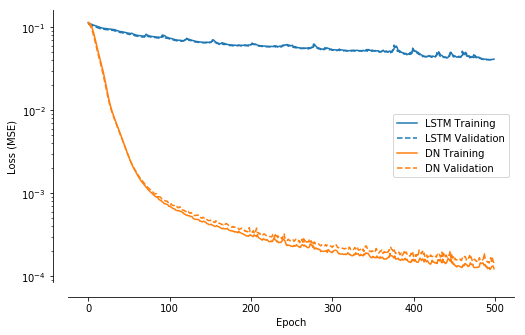

In [90]:
from phd import savefig

colors = sns.color_palette(None, 2)

plt.figure(figsize=(8, 5))
plt.plot(lstm_history.history['loss'], c=colors[0], label="LSTM Training")
plt.plot(lstm_history.history['val_loss'], c=colors[0], label="LSTM Validation", linestyle='--')

plt.plot(dn_history.history['loss'], c=colors[1], label="DN Training")
plt.plot(dn_history.history['val_loss'], c=colors[1], label="DN Validation", linestyle='--')

plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()

sns.despine(offset=15)

savefig('lstm-capacity-training.pdf')

plt.show()

In [73]:
lstm_Y = lstm_model.predict(test_X)
dn_Y = dn_model.predict(test_X)

In [85]:
from pandas import DataFrame
from collections import defaultdict
from nengolib.signal import nrmse

theta_label = r'Delay Length (# Steps)'

errors = defaultdict(list)
for name, pred_Y in (("LSTM", lstm_Y), ("DN", dn_Y)):
    for i in range(Y.shape[-1]):
        for j, case in enumerate(nrmse(pred_Y[:, :, i], target=test_Y[:, :, i], axis=1)):
            errors[theta_label].append(thetas[i] / dt)
            errors['NRMSE'].append(case)
            errors['Test'].append(j)
            errors['Method'].append(name)

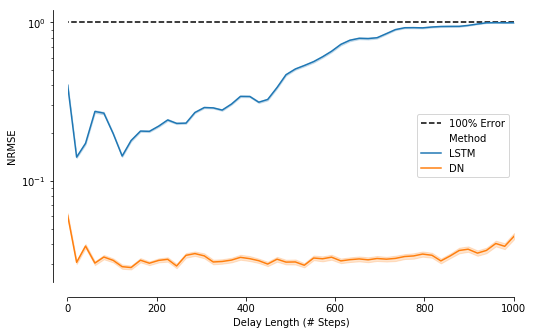

In [91]:
plt.figure(figsize=(8, 5))
plt.plot(thetas / dt, np.ones_like(thetas), linestyle='--', c='black', label="100% Error")
sns.lineplot(data=DataFrame(errors), x=theta_label, y="NRMSE", hue="Method")
#plt.xscale('log')
plt.yscale('log')
plt.xlim(np.min(errors[theta_label]), np.max(errors[theta_label]))
sns.despine(offset=15)

savefig('lstm-capacity-testing.pdf')

plt.show()

In [88]:
print(lstm_time, dn_time)

102.56023697090149 52.53427154493332
